<a href="https://colab.research.google.com/github/diegomrodrigues/transformers_experiments/blob/main/Scaled%20Dot-Product%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

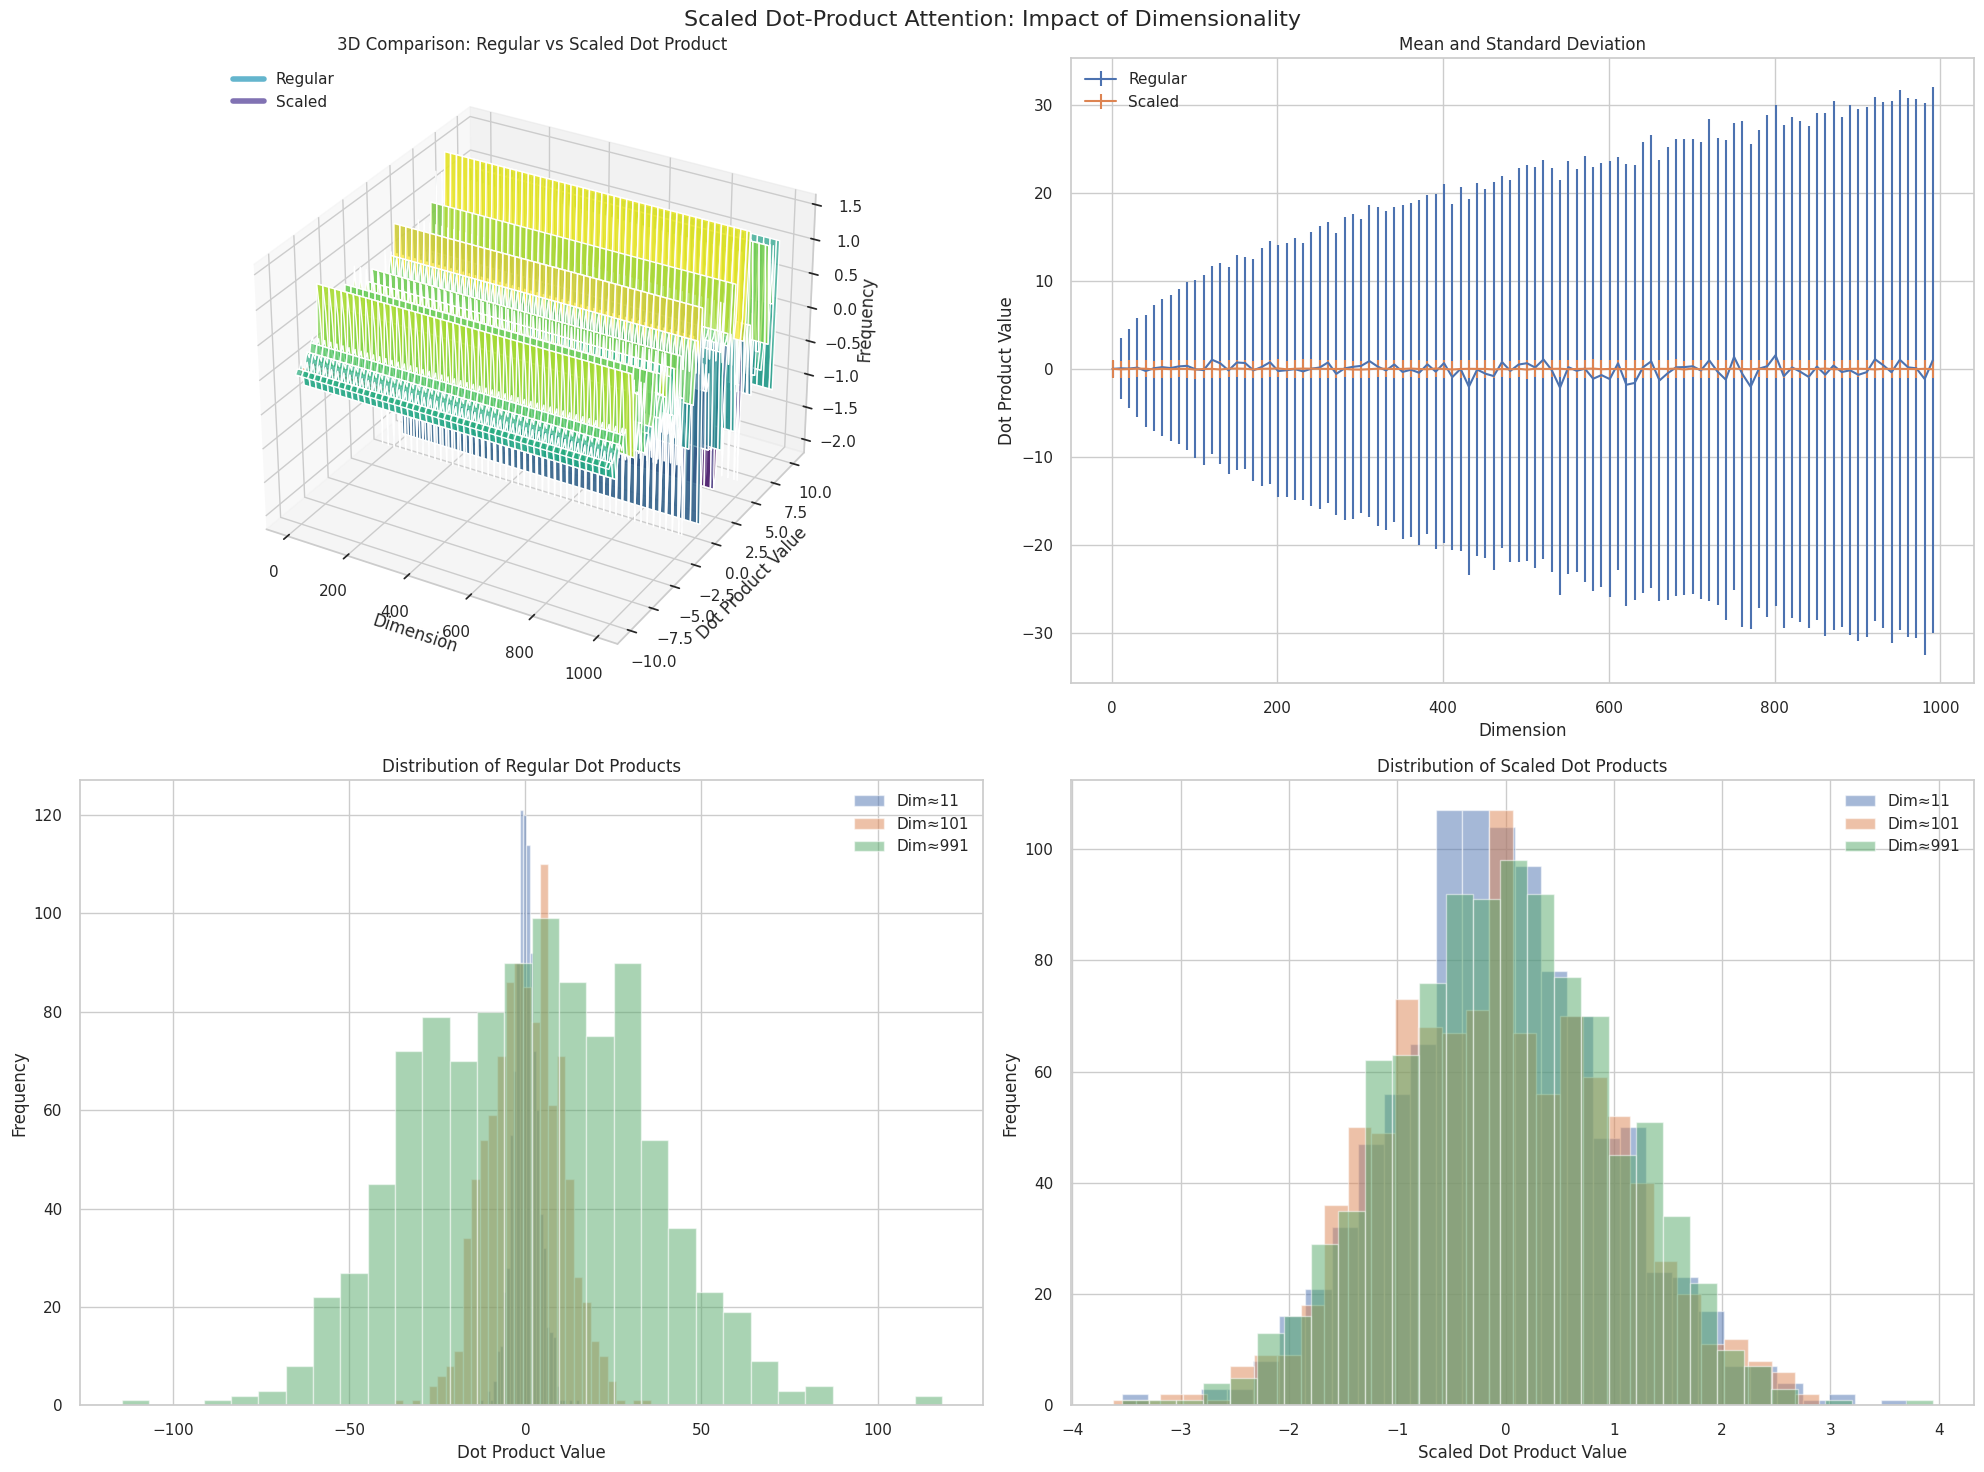

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def dot_product(dim):
    q = np.random.randn(dim)
    k = np.random.randn(dim)
    return np.dot(q, k)

def scaled_dot_product(dim):
    q = np.random.randn(dim)
    k = np.random.randn(dim)
    return np.dot(q, k) / np.sqrt(dim)

dimensions = np.arange(1, 1001, 10)
samples = 1000

# Calculate dot products
dot_products = np.array([
    [dot_product(dim) for _ in range(samples)]
    for dim in dimensions
])

scaled_dot_products = np.array([
    [scaled_dot_product(dim) for _ in range(samples)]
    for dim in dimensions
])

# Calculate statistics
mean_dot = np.mean(dot_products, axis=1)
std_dot = np.std(dot_products, axis=1)
mean_scaled = np.mean(scaled_dot_products, axis=1)
std_scaled = np.std(scaled_dot_products, axis=1)

# Create figure with subplots
fig = plt.figure(figsize=(20, 15))
fig.suptitle("Scaled Dot-Product Attention: Impact of Dimensionality", fontsize=16)

# 3D surface plot
ax1 = fig.add_subplot(221, projection='3d')
X, Y = np.meshgrid(dimensions, np.linspace(-10, 10, 100))
Z1 = np.outer(mean_dot, np.ones_like(Y[0]))
Z2 = np.outer(mean_scaled, np.ones_like(Y[0]))

surf1 = ax1.plot_surface(X, Y, Z1, cmap='viridis', alpha=0.7)
surf2 = ax1.plot_surface(X, Y, Z2, cmap='plasma', alpha=0.7)
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Dot Product Value')
ax1.set_zlabel('Frequency')
ax1.set_title('3D Comparison: Regular vs Scaled Dot Product')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='c', lw=4, label='Regular'),
                   Line2D([0], [0], color='m', lw=4, label='Scaled')]
ax1.legend(handles=legend_elements, loc='upper left')

# 2D plot with error bars
ax2 = fig.add_subplot(222)
ax2.errorbar(dimensions, mean_dot, yerr=std_dot, capsize=2, label='Regular')
ax2.errorbar(dimensions, mean_scaled, yerr=std_scaled, capsize=2, label='Scaled')
ax2.set_xlabel('Dimension')
ax2.set_ylabel('Dot Product Value')
ax2.set_title('Mean and Standard Deviation')
ax2.legend()

# Histogram for specific dimensions
dims_to_plot = [10, 100, 1000]
ax3 = fig.add_subplot(223)
for dim in dims_to_plot:
    idx = np.abs(dimensions - dim).argmin()
    actual_dim = dimensions[idx]
    ax3.hist(dot_products[idx], bins=30, alpha=0.5, label=f'Dim≈{actual_dim}')
ax3.set_xlabel('Dot Product Value')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Regular Dot Products')
ax3.legend()

ax4 = fig.add_subplot(224)
for dim in dims_to_plot:
    idx = np.abs(dimensions - dim).argmin()
    actual_dim = dimensions[idx]
    ax4.hist(scaled_dot_products[idx], bins=30, alpha=0.5, label=f'Dim≈{actual_dim}')
ax4.set_xlabel('Scaled Dot Product Value')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Scaled Dot Products')
ax4.legend()

plt.tight_layout()
plt.show()

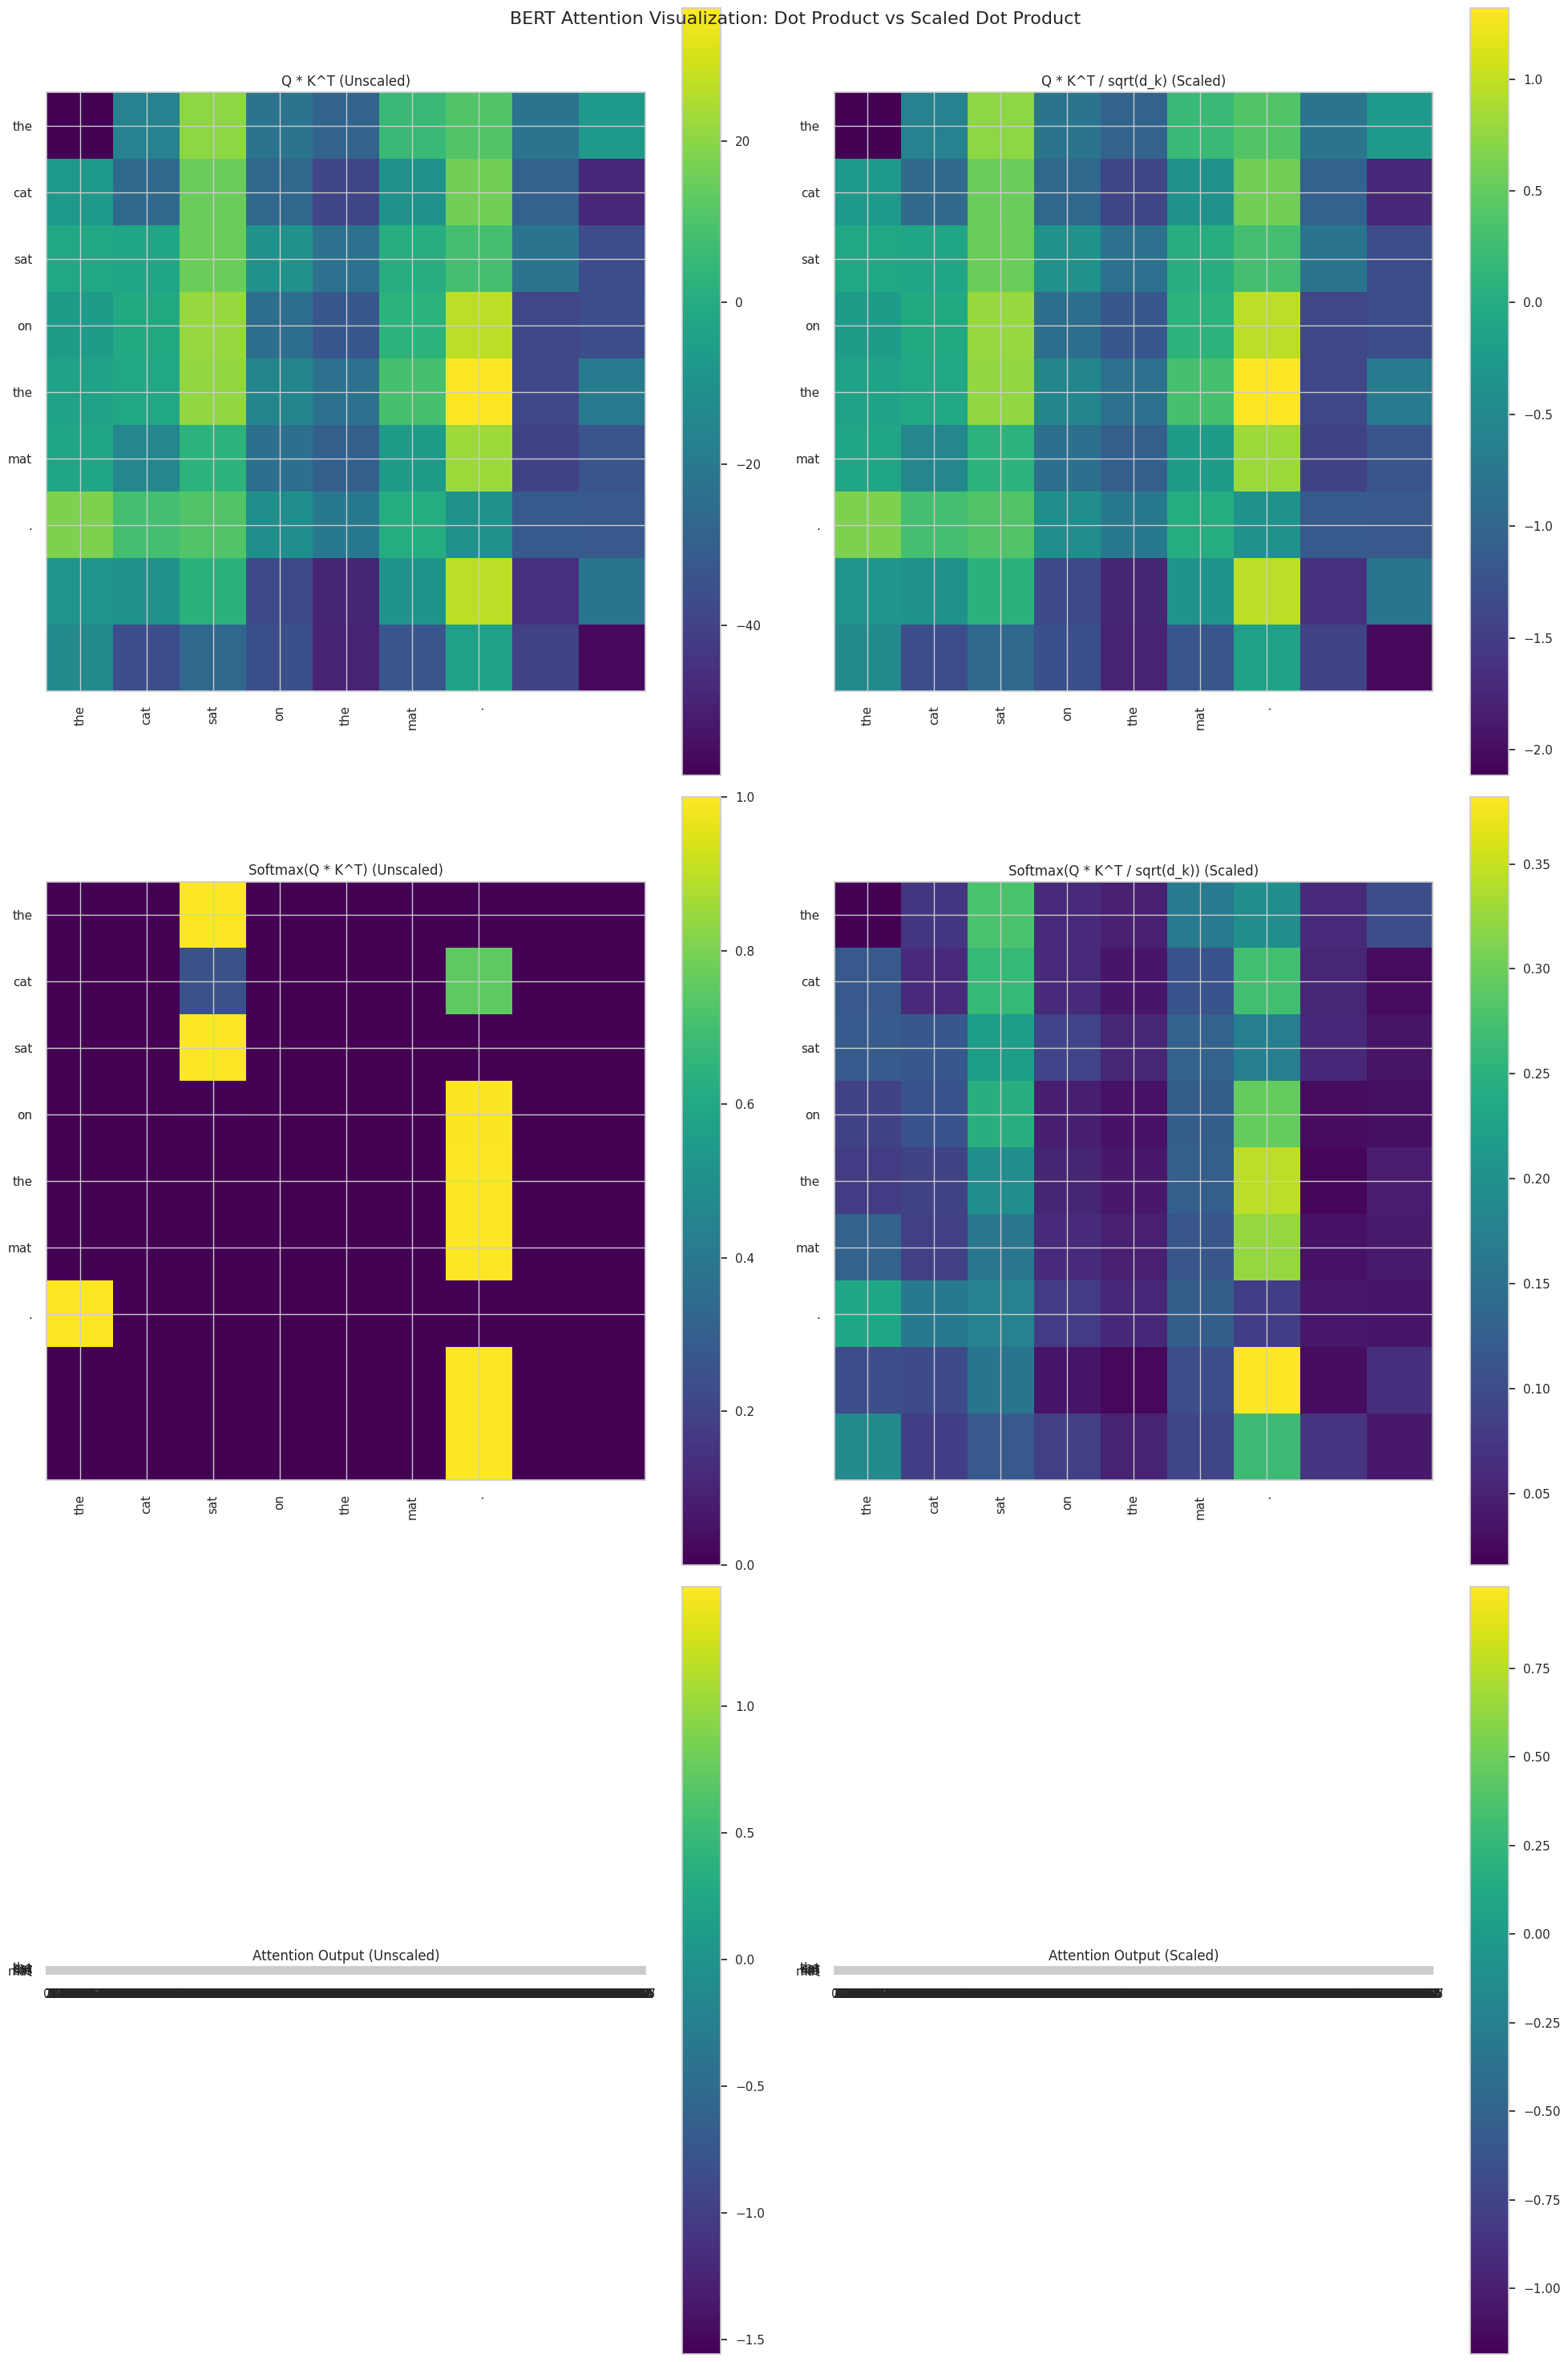

In [44]:
import torch
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import numpy as np

# Carregar modelo BERT pré-treinado e tokenizador
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Função para obter Q, K, V de uma camada específica
def get_qkv(model, layer_idx, text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    attention = outputs.attentions[layer_idx]
    q = model.encoder.layer[layer_idx].attention.self.query(outputs.last_hidden_state)
    k = model.encoder.layer[layer_idx].attention.self.key(outputs.last_hidden_state)
    v = model.encoder.layer[layer_idx].attention.self.value(outputs.last_hidden_state)
    return q.squeeze(0), k.squeeze(0), v.squeeze(0), attention.squeeze(0)

# Função para calcular a atenção com e sem escala
def calculate_attention(q, k, v, scale=True):
    d_k = q.size(-1)
    if scale:
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)
    else:
        scores = torch.matmul(q, k.transpose(-2, -1))
    attention_weights = torch.softmax(scores, dim=-1)
    attention_output = torch.matmul(attention_weights, v)
    return scores, attention_weights, attention_output

# Função para criar visualização comparativa
def visualize_attention_comparison(q, k, v, attention, tokens):
    fig, axs = plt.subplots(3, 2, figsize=(20, 30))
    fig.suptitle("BERT Attention Visualization: Dot Product vs Scaled Dot Product", fontsize=16)

    # Calcular atenção sem e com escala
    scores_unscaled, weights_unscaled, output_unscaled = calculate_attention(q, k, v, scale=False)
    scores_scaled, weights_scaled, output_scaled = calculate_attention(q, k, v, scale=True)

    # Plot 1: Q * K^T (Unscaled)
    ax = axs[0, 0]
    im = ax.imshow(scores_unscaled.detach().numpy(), cmap='viridis')
    ax.set_title("Q * K^T (Unscaled)")
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    plt.colorbar(im, ax=ax)

    # Plot 2: Q * K^T / sqrt(d_k) (Scaled)
    ax = axs[0, 1]
    im = ax.imshow(scores_scaled.detach().numpy(), cmap='viridis')
    ax.set_title("Q * K^T / sqrt(d_k) (Scaled)")
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    plt.colorbar(im, ax=ax)

    # Plot 3: Softmax(Q * K^T) (Unscaled)
    ax = axs[1, 0]
    im = ax.imshow(weights_unscaled.detach().numpy(), cmap='viridis')
    ax.set_title("Softmax(Q * K^T) (Unscaled)")
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    plt.colorbar(im, ax=ax)

    # Plot 4: Softmax(Q * K^T / sqrt(d_k)) (Scaled)
    ax = axs[1, 1]
    im = ax.imshow(weights_scaled.detach().numpy(), cmap='viridis')
    ax.set_title("Softmax(Q * K^T / sqrt(d_k)) (Scaled)")
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(tokens)
    plt.colorbar(im, ax=ax)

    # Plot 5: Attention Output (Unscaled)
    ax = axs[2, 0]
    im = ax.imshow(output_unscaled.detach().numpy(), cmap='viridis')
    ax.set_title("Attention Output (Unscaled)")
    ax.set_xticks(range(output_unscaled.size(1)))
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens)
    plt.colorbar(im, ax=ax)

    # Plot 6: Attention Output (Scaled)
    ax = axs[2, 1]
    im = ax.imshow(output_scaled.detach().numpy(), cmap='viridis')
    ax.set_title("Attention Output (Scaled)")
    ax.set_xticks(range(output_scaled.size(1)))
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens)
    plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

# Texto de exemplo
text = "The cat sat on the mat."

# Obter tokens
tokens = tokenizer.tokenize(text)

# Obter Q, K, V e atenção da primeira camada
layer_idx = 0
q, k, v, attention = get_qkv(model, layer_idx, text)

# Visualizar comparação de atenção
visualize_attention_comparison(q, k, v, attention, tokens)

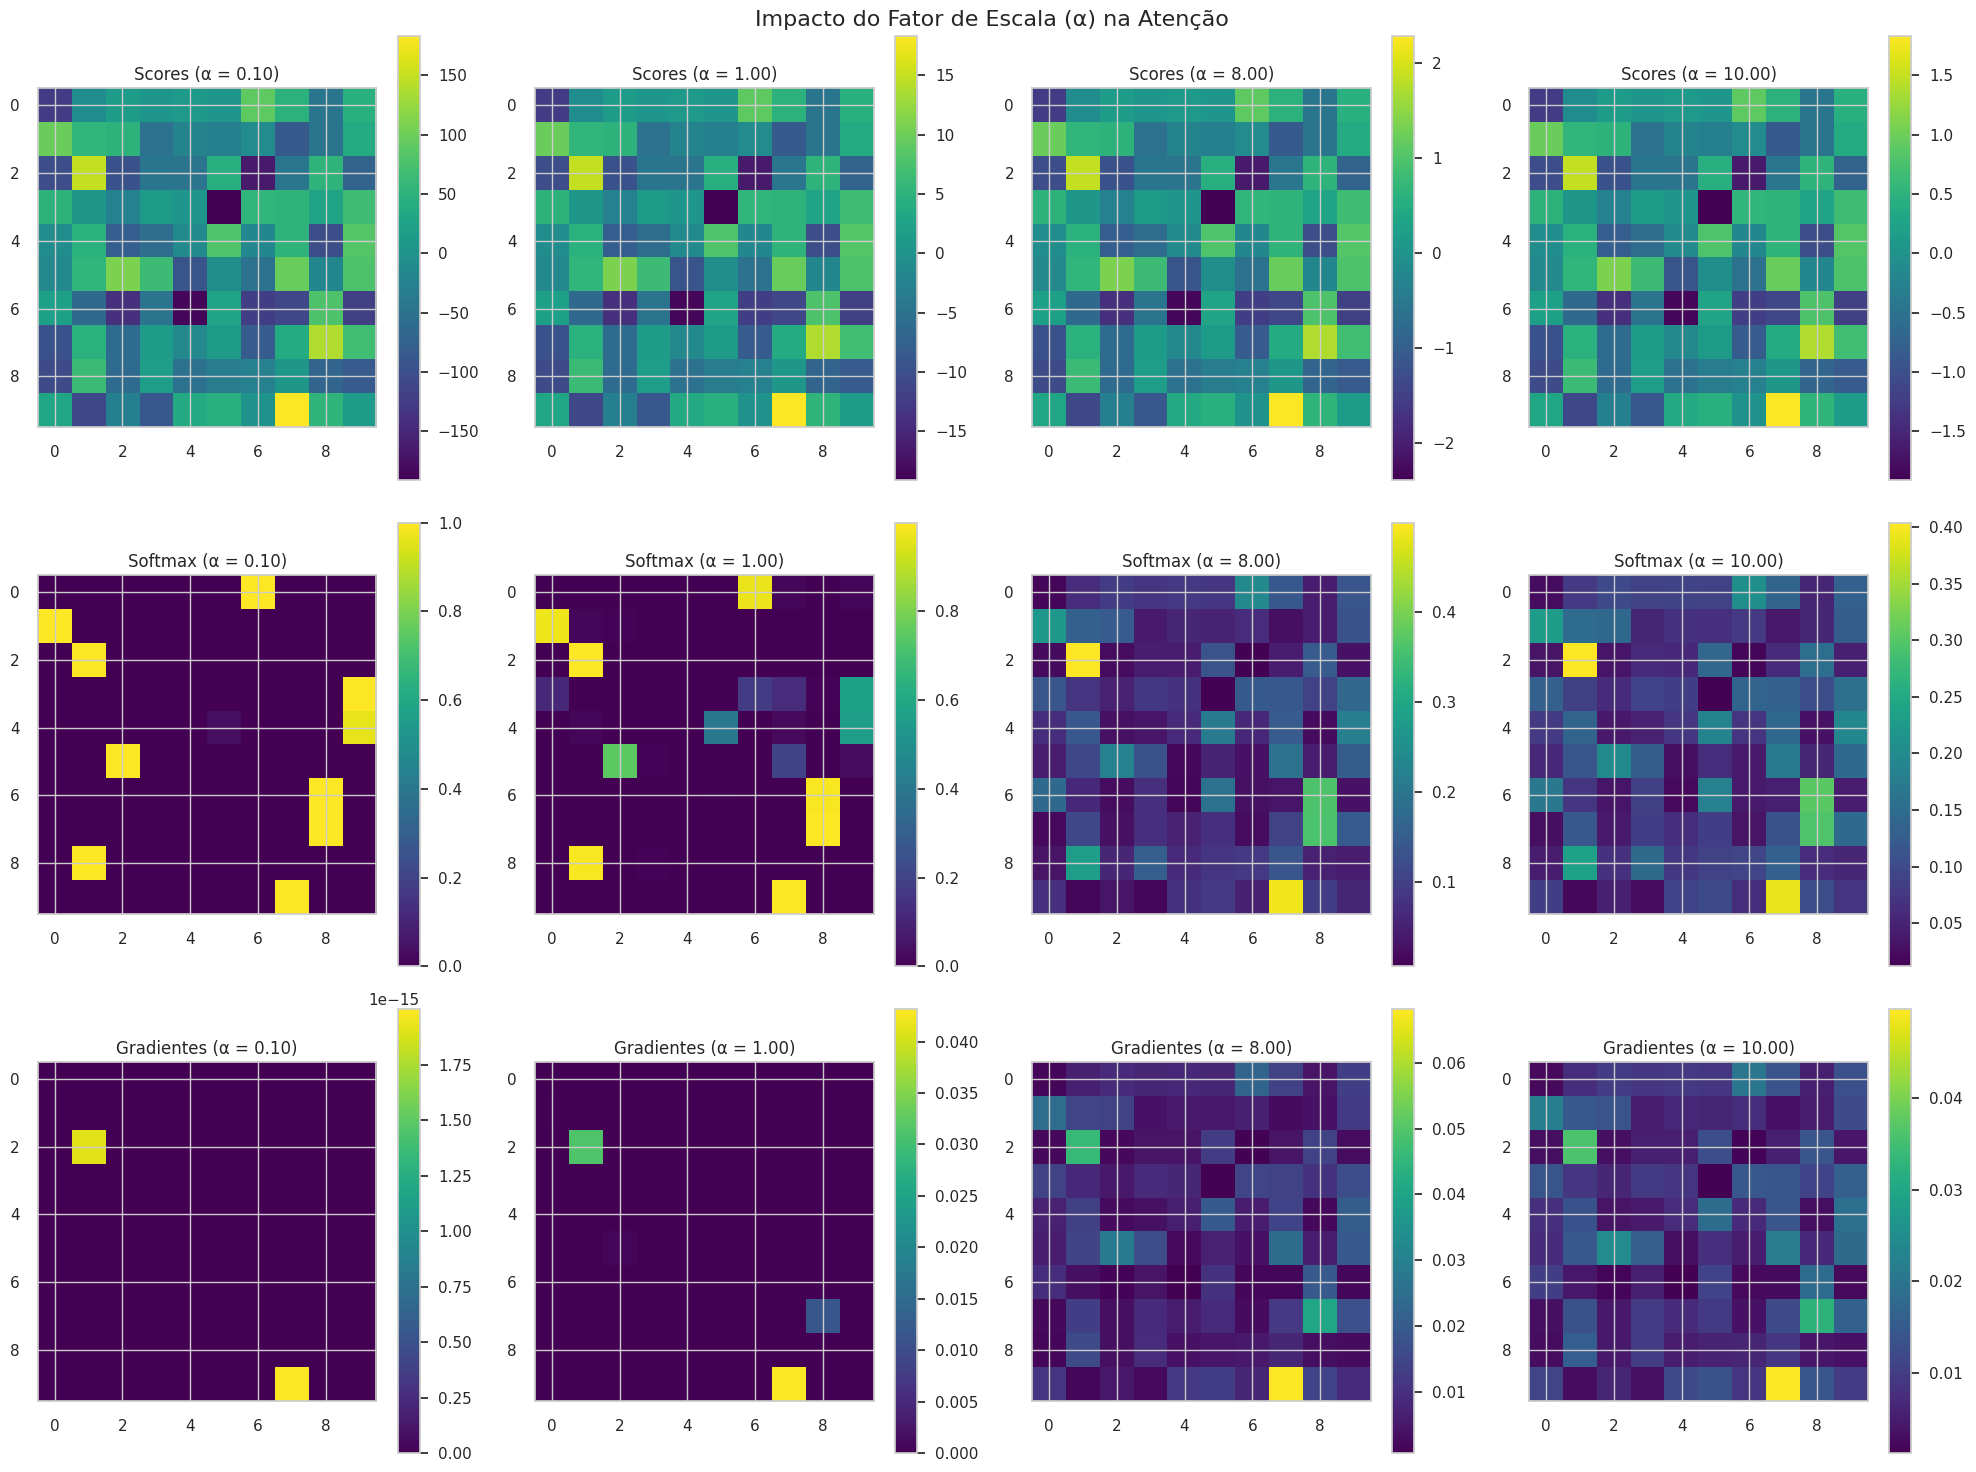

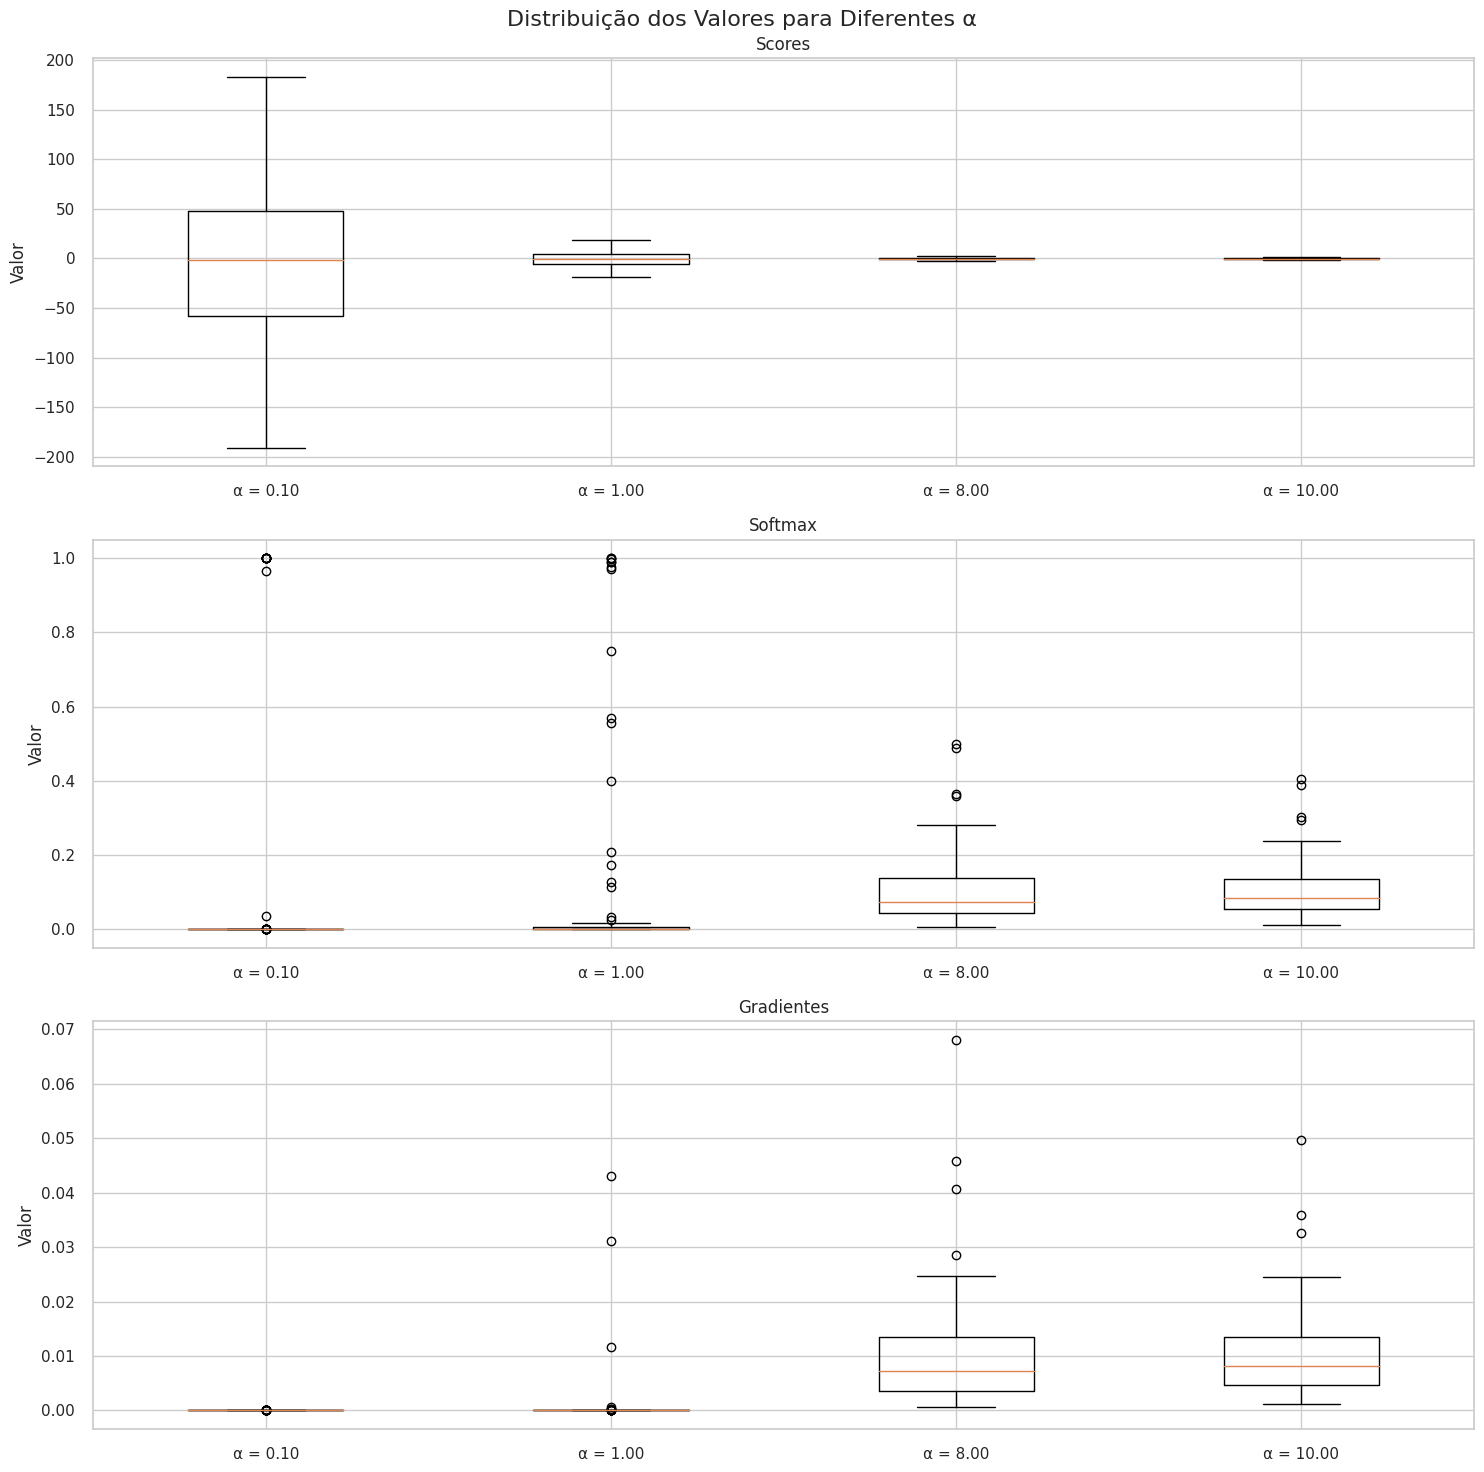

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

def attention_scores(Q, K, alpha):
    return np.dot(Q, K.T) / alpha

def softmax_gradient(x):
    s = softmax(x)
    return s * (1 - s)

# Configurações
d_k = 64  # dimensão das queries/keys
n = 10    # número de elementos na sequência

# Gerar Q e K aleatórios
np.random.seed(42)
Q = np.random.randn(n, d_k)
K = np.random.randn(n, d_k)

# Valores de alpha para testar
alphas = [0.1, 1, np.sqrt(d_k), 10]

# Configurar o plot
fig, axs = plt.subplots(3, len(alphas), figsize=(20, 15))
fig.suptitle("Impacto do Fator de Escala (α) na Atenção", fontsize=16)

for i, alpha in enumerate(alphas):
    # Calcular scores de atenção
    scores = attention_scores(Q, K, alpha)

    # Calcular softmax
    probs = softmax(scores, axis=-1)

    # Calcular gradientes
    grads = softmax_gradient(scores)

    # Plot scores
    ax = axs[0, i]
    im = ax.imshow(scores, cmap='viridis')
    ax.set_title(f"Scores (α = {alpha:.2f})")
    plt.colorbar(im, ax=ax)

    # Plot softmax
    ax = axs[1, i]
    im = ax.imshow(probs, cmap='viridis')
    ax.set_title(f"Softmax (α = {alpha:.2f})")
    plt.colorbar(im, ax=ax)

    # Plot gradientes
    ax = axs[2, i]
    im = ax.imshow(grads, cmap='viridis')
    ax.set_title(f"Gradientes (α = {alpha:.2f})")
    plt.colorbar(im, ax=ax)

# Ajustar layout
plt.tight_layout()
plt.show()

# Análise adicional: distribuição dos valores
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle("Distribuição dos Valores para Diferentes α", fontsize=16)

for i, (title, data) in enumerate([
    ("Scores", [attention_scores(Q, K, alpha).flatten() for alpha in alphas]),
    ("Softmax", [softmax(attention_scores(Q, K, alpha), axis=-1).flatten() for alpha in alphas]),
    ("Gradientes", [softmax_gradient(attention_scores(Q, K, alpha)).flatten() for alpha in alphas])
]):
    ax = axs[i]
    ax.boxplot(data, labels=[f"α = {alpha:.2f}" for alpha in alphas])
    ax.set_title(title)
    ax.set_ylabel("Valor")

plt.tight_layout()
plt.show()